# Credit Card Fraud - Anomaly (Detection신용카드 사기 탐지)
설명: 신용카드 거래 데이터를 분석하여 정상 거래와 사기 거래를 분류하는 문제 (불균형 데이터)

### Outline (분석 과정)

데이터 로드 및 전처리
>- 신용카드 거래 데이터 로드
>- `class`를 `label`로 변경, `amount` log 변환
>- `time`, `amount` 컬럼 제거

데이터 탐색(EDA) 및 데이터 분활 
>- 변수 분포 시각화 (histogram)
>- 데이터 불균형 확인 (정상거래 99% 이상)
>- Train/Test 데이터 분리
>- ML용, AE용 데이터 분리
>- 거래 금액 정규화 (MinMax)

Models
>기본 모델  
>- `로지스틱 회귀`, `Decision Tree`
>고급 모델  
>- `Random Forest`, `XGBoost`, `Isolation Forest`
>딥러닝  
>- `Autoencoder 기반 이상탐지`

성능평가 
>- PR Curve
>
>- ROC Curve

## Data Load

In [98]:
import pandas as pd 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib inline
import random as rn

In [99]:
# 데이터셋 블러오기
df = pd.read_csv('data/creditcard.csv')

# 파라미터 설정
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Data Preprocessing

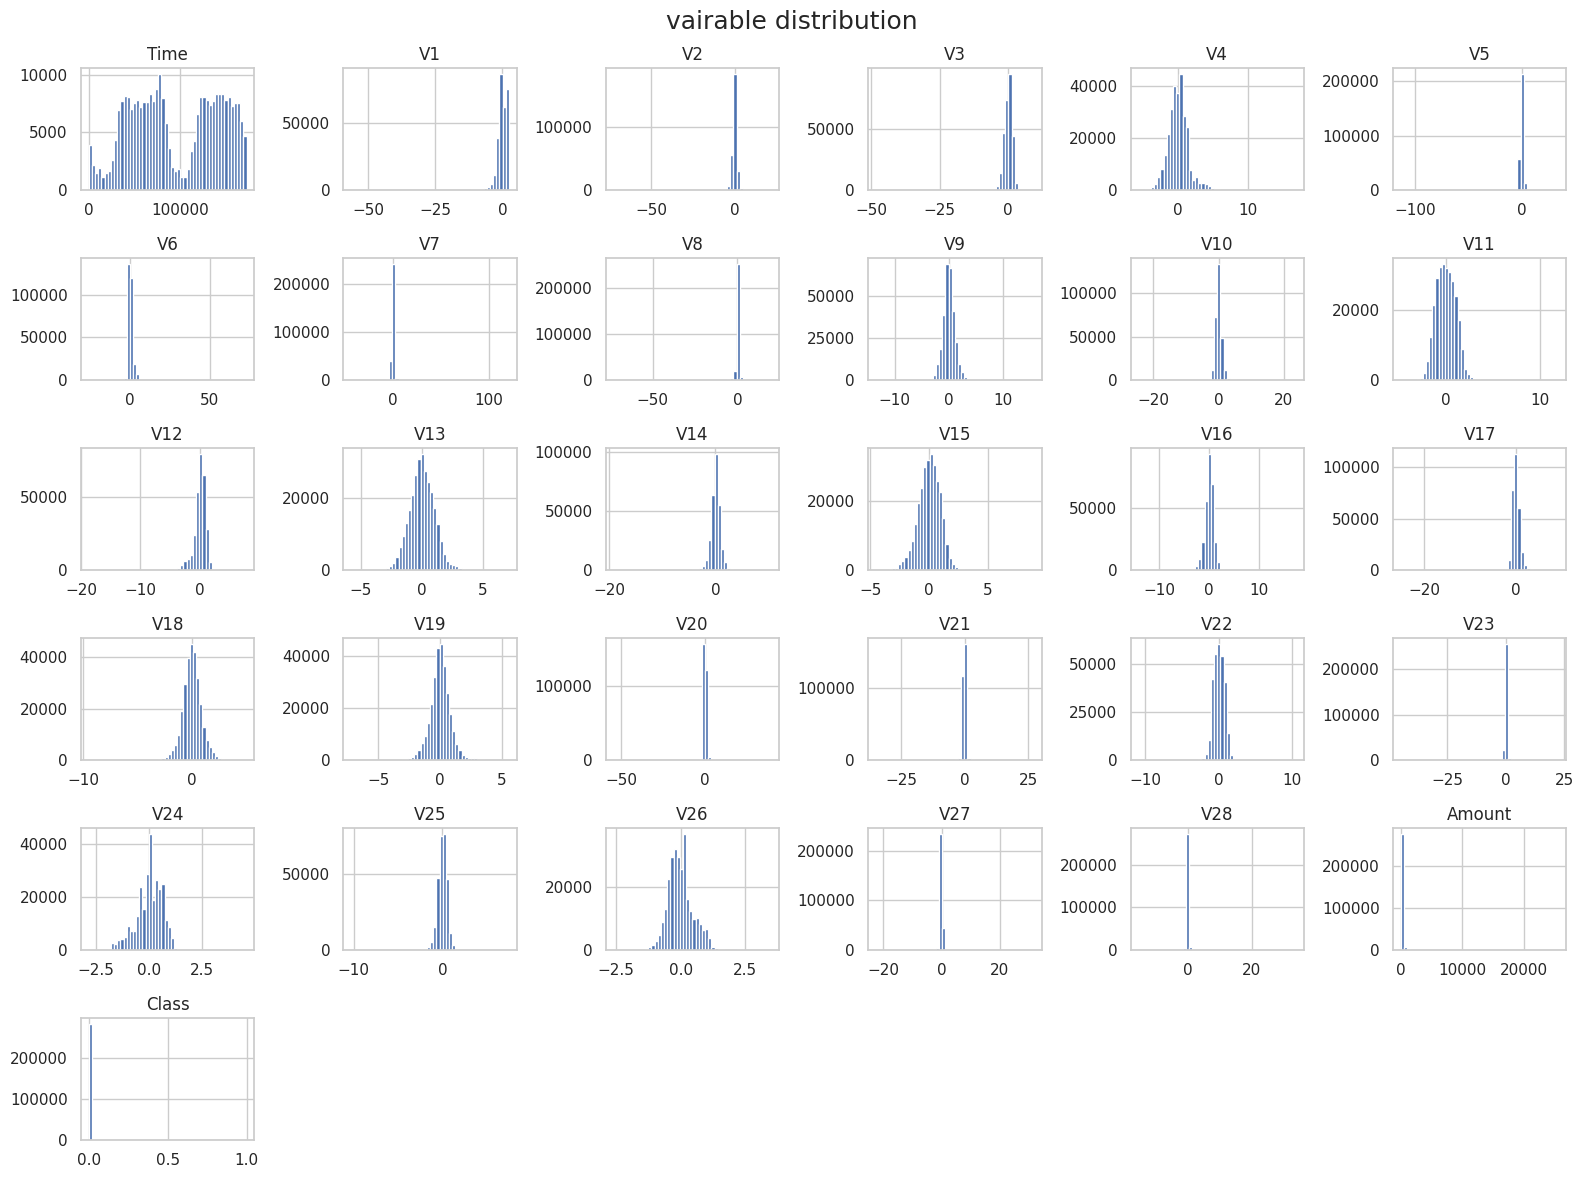

In [100]:
df.hist(figsize=(16,12), bins=50)
plt.suptitle("vairable distribution", fontsize=18)
plt.tight_layout()
plt.show()

Graph를 보니 대체로 정규 분포를 따르는 형태를 보임.  
amount는 거래량을 의미해서 log를 씌워 좀 더 명확한 값을 가져가는게 성능에 좋아보임.

추가로, 모든 열의 이름 소문자 처리 후 class를 lable로 이름 변경

In [101]:
df.columns = map(str.lower, df.columns)
df.rename(columns={'class': 'label'}, inplace=True)
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


추가로 amount 특성을 정규 분포처럼 만들기 위해 로그 변환을 적용

In [102]:
df['log10_amount'] = np.log10(df.amount + 0.00001) # 0 방지를 위해 더해 줌
df = df[
    [col for col in df if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

불필요한 열 제거 및 label을 정상거래와 비정상 거래로 분리

참고로, AutoEncoder를 이용할 시에는 비정상은 학습에 사용하지 않으므로 필요없음. 다만 ML을 이용할 때 쓰려고 SMOTE or UnderSampling 진행

In [103]:
# 불필요한 열 제거
df = df.drop(['time', 'amount'], axis=1)
# df = df.drop(['time'], axis=1)

# 라벨로 분리
fraud = df[df.label == 1]
clean = df[df.label == 0]

In [104]:
df.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v21,v22,v23,v24,v25,v26,v27,v28,log10_amount,label
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,1.264716,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.953123,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-5.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.748189,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,1.342423,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,1.887420,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,4.409784,1.000000


In [105]:
# 클래스 분포 확인
print("정상/사기 거래 수:")
print(df['label'].value_counts())
print("클래스 비율 (%):")
print(df['label'].value_counts(normalize=True) * 100)

정상/사기 거래 수:
label
0    284315
1       492
Name: count, dtype: int64
클래스 비율 (%):
label
0    99.827251
1     0.172749
Name: proportion, dtype: float64


현재 정상거래의 비율이 약 99%에 해당함 굉장히 불균형한 데이터

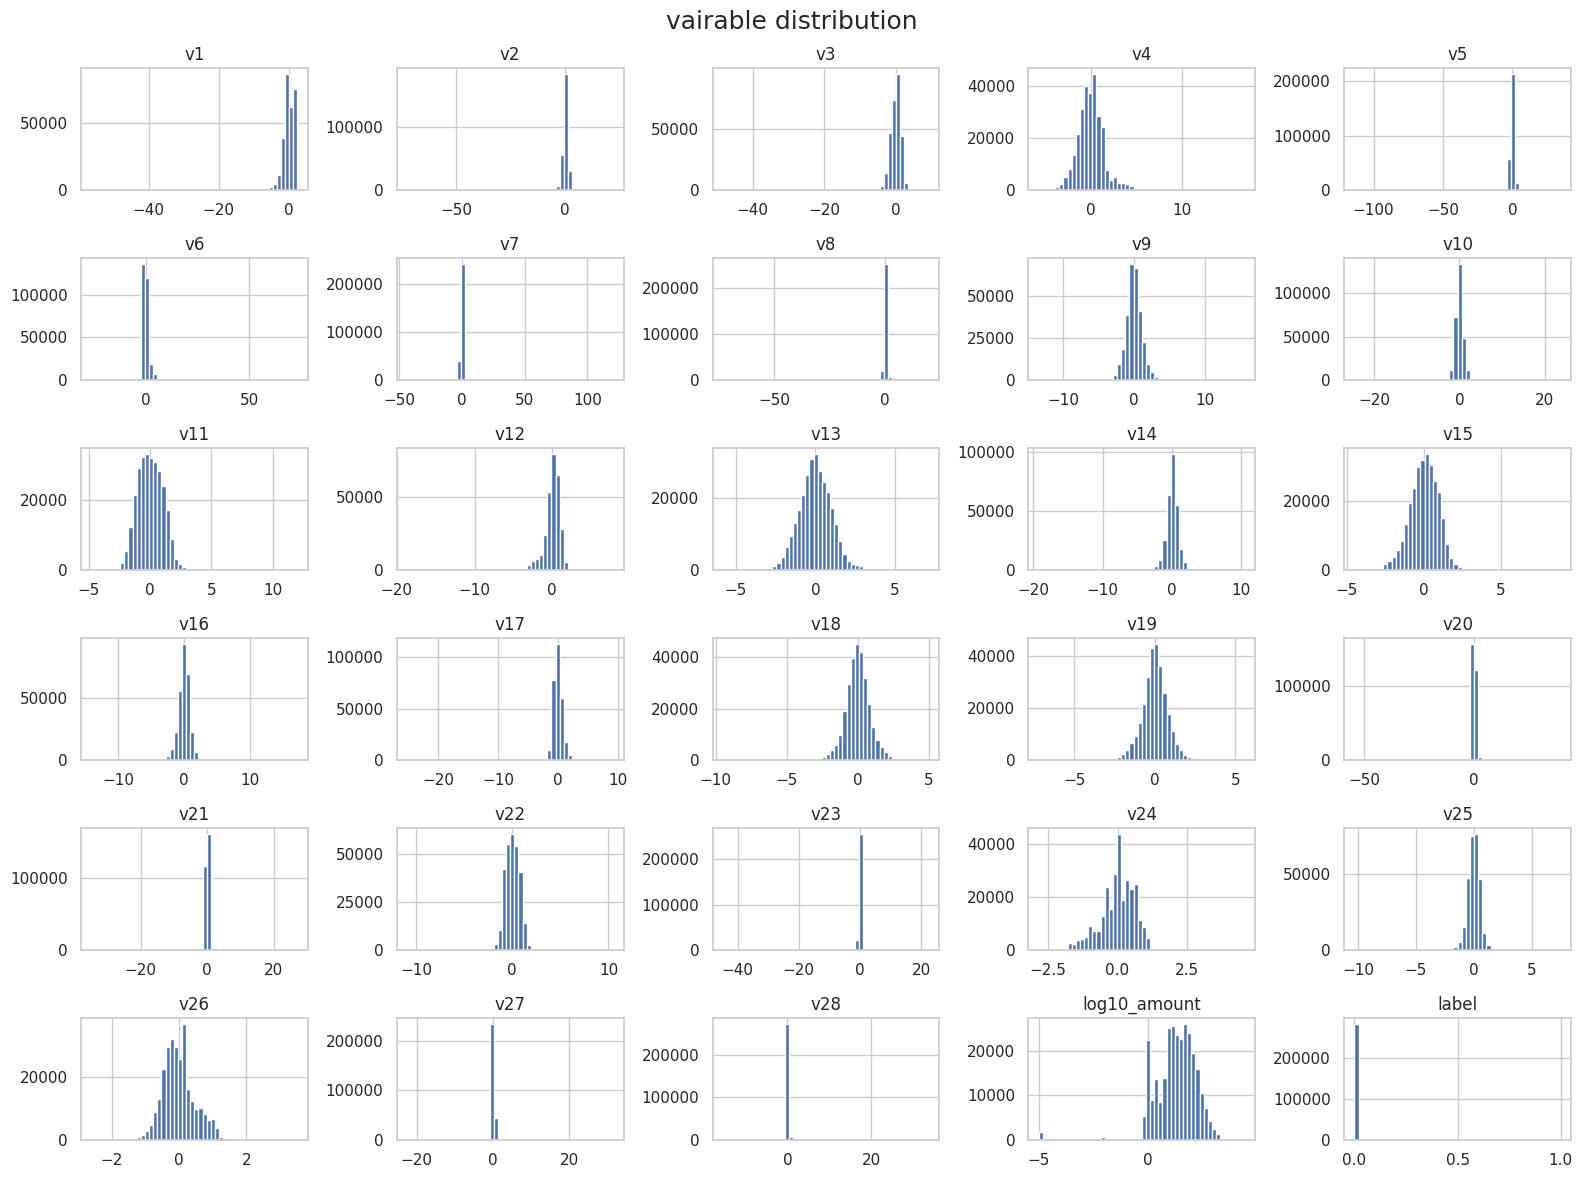

In [106]:
df.hist(figsize=(16,12), bins=50)
plt.suptitle("vairable distribution", fontsize=18)
plt.tight_layout()
plt.show()

여기서부터 ML기반과 AE 기반으로 나눠서 데이터를 사용 ML은 불균형 데이터 처리를 해줘야하는 과정  

AE는 오직 normal transactions(정상 거래)을 학습 시켜 model이 정확하게 reconstruction 하도록 함  

>그 결과, 사기 거래가 정상 거래와 충분히 다르면, AE는 이를 잘 재구성하지 못하고, 재구성 오차(reconstruction loss) 가 커짐  
>
>재구성 오차가 특정 임계값(threshold)을 넘는 경우, 이상(anomalous) 으로 간주하고 사기로 분류

### Models
>기본 모델
>- `로지스틱 회귀`, `Decision Tree`
>
>고급 모델
>- `Random Forest`, `XGBoost`, `Isolation Forest`
>
>딥러닝
>- `Autoencoder 기반 이상탐지`

### ML 기반 model 방식


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score

학습하는 과정을 ML은 하나로 통합

In [108]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Model'):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    print(f"{model_name} - Classification Report")
    print(classification_report(y_test, y_pred, digits=4))

    auc_score = roc_auc_score(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)
    print(f"AUC: {auc_score:.4f} / Average Precision: {ap_score:.4f}")
    return y_pred, y_proba

ML은 oversmapling 기법인 SMOTE 적용  
다만, test에는 smote를 적용하면 안되므로 미리 분류

In [109]:
# 분류
from sklearn.model_selection import train_test_split

# 공통 데이터 분할
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED)

# 공통 테스트셋
X_test_common = df_test.drop('label', axis=1).values
y_test_common = df_test['label'].values


# 학습 데이터 분리
X_train = df_train.drop('label', axis=1).values
y_train = df_train['label'].values


Oversampling을 진행한 경우

In [110]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=RANDOM_SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("SMOTE 후 학습셋 클래스 분포:")
print(pd.Series(y_train_balanced).value_counts())

SMOTE 후 학습셋 클래스 분포:
0    227451
1    227451
Name: count, dtype: int64


oversampling인 SMOTE를 적용하면 학습 시간이 너무 오래 걸려 under로 진행

#### Undersampling을 진행

In [111]:
# 사기 거래 수만큼 정상 거래 샘플링
fraud_train = df_train[df_train.label == 1]
clean_train = df_train[df_train.label == 0]

# undersample 정상 거래
clean_sampled = clean_train.sample(n=len(fraud_train), random_state=RANDOM_SEED)
df_ml_train = pd.concat([clean_sampled, fraud_train]).sample(frac=1, random_state=RANDOM_SEED)

# 학습용 feature, label 분리
X_train_ml = df_ml_train.drop('label', axis=1).values
y_train_ml = df_ml_train['label'].values


Data scaling 적용

In [112]:
from sklearn.preprocessing import MinMaxScaler

scaler_ml = MinMaxScaler()

X_train_ml = scaler_ml.fit_transform(X_train_ml) # ML용 학습 데이터
X_test_common = scaler_ml.transform(X_test_common)


머신러닝 모델 정의 (undersampling 이용)


In [113]:
# 모델 정의
logistic = LogisticRegression(max_iter=1000)
dtree = DecisionTreeClassifier(random_state=RANDOM_SEED)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)
isolation_forest = IsolationForest(contamination=0.01, random_state=RANDOM_SEED) 

results = {}

# 전체 모델 학습 및 평가
for model, name in zip(
    [logistic, dtree, rf, xgb, isolation_forest],
    ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Isolation Forest']
):
    print("="*70)
    
    if name == 'Isolation Forest':
        model.fit(X_train_ml)
        y_pred = model.predict(X_test_common)
        y_pred = np.where(y_pred == 1, 0, 1)  # Isolation Forest 특성 반영
        y_proba = -model.decision_function(X_test_common)  # 정상 거래에 score가 크니까 반전
    else:
        y_pred, y_proba = train_and_evaluate_model(model, X_train_ml, y_train_ml, X_test_common, y_test_common, model_name=name)
    
    results[name] = {
        'y_pred': y_pred,
        'y_proba': y_proba
    }


/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9951    0.9974     56864
           1     0.2301    0.8571    0.3629        98

    accuracy                         0.9948     56962
   macro avg     0.6149    0.9261    0.6801     56962
weighted avg     0.9984    0.9948    0.9963     56962

AUC: 0.9659 / Average Precision: 0.6950
Decision Tree - Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9054    0.9503     56864
           1     0.0159    0.8878    0.0313        98

    accuracy                         0.9054     56962
   macro avg     0.5079    0.8966    0.4908     56962
weighted avg     0.9981    0.9054    0.9487     56962

AUC: 0.8966 / Average Precision: 0.0143
Random Forest - Classification Report
              precision    recall  f1-score   support

           0     0.9998    0.9768    0.9882     56864
           1     0.0612    0.8776    

### ML 모델 PR Curve / ROC Curve 시각화

In [114]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# PR Curve 시각화 함수
def plot_pr_curves(results, y_test):
    plt.figure(figsize=(8,6))
    
    for model_name, output in results.items():
        y_score = output['y_proba']
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{model_name} (AP={ap:.4f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

# ROC Curve 시각화 함수
def plot_roc_curves(results, y_test):
    plt.figure(figsize=(8,6))
    
    for model_name, output in results.items():
        y_score = output['y_proba']
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc:.4f})")
    
    plt.plot([0,1], [0,1], 'k--', lw=2)  # 대각선 기준선
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


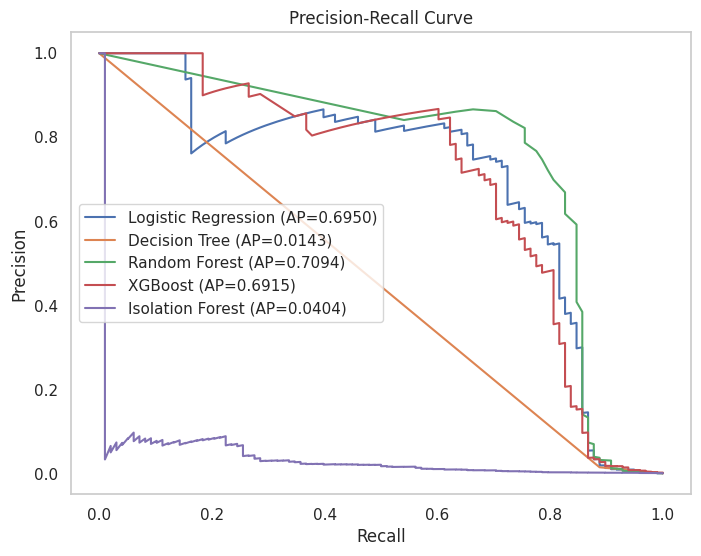

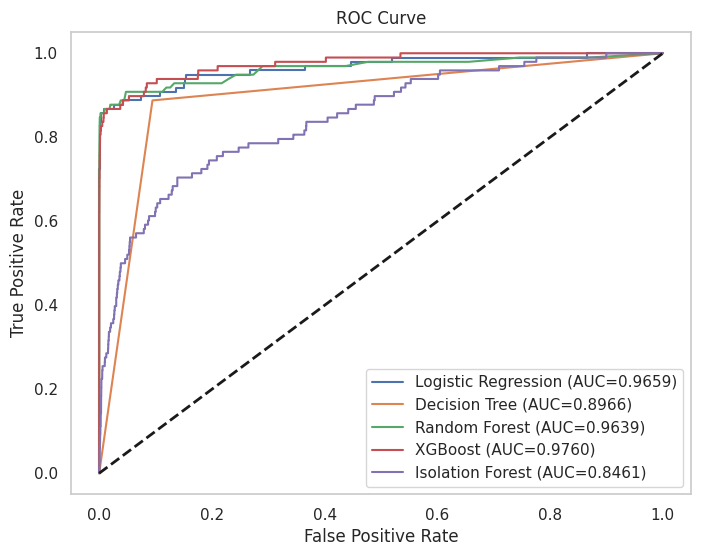

In [115]:
# PR Curve
plot_pr_curves(results, y_test_common)

# ROC Curve
plot_roc_curves(results, y_test_common)


Undersampling을 사용하다보니 성능이 좋진 않음

### Autoencoder (AE) 모델 설계 및 학습
>AE를 사용하는 방식은 기존 방식들과 차이점이 존재 
> 
>기존 supervised 방식이 아니라 self-supervised learning을 활용해 자기 자신의 분포(data의 분포)를 배우고 그거와 다르면 이상치로 감자하는 메커니즘

Train / Test data 구성

In [116]:
# 검증용: 학습용에서 다시 나누기
from sklearn.model_selection import train_test_split
X_train_ae = clean_train.drop('label', axis=1)
X_train_ae, X_val_ae = train_test_split(X_train_ae, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)

# AE용 테스트셋은 '원본' 피처를 다시 꺼내서 사용
X_test_ae = df_test.drop('label', axis=1)  # DataFrame 그대로 유지
y_test_ae = df_test['label'].values


# AE용 스케일러 정의 및 fit
scaler_ae = MinMaxScaler()
scaler_ae.fit(X_train_ae)  # 오직 X_train_ae만 가지고 학습

# Train, Validation, Test 모두 같은 스케일러 적용
X_train_ae_scaled = scaler_ae.transform(X_train_ae)
X_val_ae_scaled   = scaler_ae.transform(X_val_ae)
X_test_ae_scaled  = scaler_ae.transform(X_test_ae)

#### AE model 정의

In [117]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 16),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, input_dim),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


#### Data scaling 및 tensor로 변환

In [118]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. Device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 2. numpy array → tensor 변환
X_train_tensor = torch.tensor(X_train_ae_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_ae_scaled, dtype=torch.float32)

# 3. Dataloader 생성 (self-supervised learning이므로 입력=정답 구조 유지)
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, X_val_tensor), batch_size=256, shuffle=False)

# 4. 모델 초기화
input_dim = X_train_ae_scaled.shape[1]
model_ae = AutoEncoder(input_dim).to(device)

# 5. 손실함수, 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4)


AE training

In [119]:
num_epochs = 50

best_val_loss = np.inf
best_model = None

for epoch in range(num_epochs):
    model_ae.train()
    train_loss = 0
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_hat = model_ae(x_batch)
        loss = criterion(x_hat, x_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # 검증
    model_ae.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, _ in val_loader:
            x_batch = x_batch.to(device)
            x_hat = model_ae(x_batch)
            loss = criterion(x_hat, x_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # 최적 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model_ae.state_dict()

    print(f"Epoch {epoch+1:02}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")


Epoch 01/50 | Train Loss: 0.131310 | Val Loss: 0.015785
Epoch 02/50 | Train Loss: 0.024349 | Val Loss: 0.005632
Epoch 03/50 | Train Loss: 0.013927 | Val Loss: 0.003675
Epoch 04/50 | Train Loss: 0.009711 | Val Loss: 0.002955
Epoch 05/50 | Train Loss: 0.007419 | Val Loss: 0.002645
Epoch 06/50 | Train Loss: 0.006026 | Val Loss: 0.002463
Epoch 07/50 | Train Loss: 0.005096 | Val Loss: 0.002332
Epoch 08/50 | Train Loss: 0.004410 | Val Loss: 0.002198
Epoch 09/50 | Train Loss: 0.003917 | Val Loss: 0.002062
Epoch 10/50 | Train Loss: 0.003538 | Val Loss: 0.001877
Epoch 11/50 | Train Loss: 0.003209 | Val Loss: 0.001773
Epoch 12/50 | Train Loss: 0.002973 | Val Loss: 0.001682
Epoch 13/50 | Train Loss: 0.002753 | Val Loss: 0.001603
Epoch 14/50 | Train Loss: 0.002596 | Val Loss: 0.001500
Epoch 15/50 | Train Loss: 0.002450 | Val Loss: 0.001471
Epoch 16/50 | Train Loss: 0.002327 | Val Loss: 0.001352
Epoch 17/50 | Train Loss: 0.002221 | Val Loss: 0.001330
Epoch 18/50 | Train Loss: 0.002131 | Val Loss: 0

In [120]:
# 1. Best Model 불러오기
model_ae.load_state_dict(best_model)
model_ae.eval()

# 2. 테스트셋 → Tensor 변환
X_test_tensor = torch.tensor(X_test_ae_scaled, dtype=torch.float32).to(device)

# 3. 재구성 실행
with torch.no_grad():
    X_recon = model_ae(X_test_tensor).cpu().numpy()

# 4. 재구성 오차 계산 (MSE per row)
import numpy as np
reconstruction_errors = np.mean((X_test_ae_scaled - X_recon)**2, axis=1)

In [121]:
from sklearn.metrics import f1_score

thresholds = np.linspace(np.min(reconstruction_errors), np.max(reconstruction_errors), 100)

f1_scores = []
for thresh in thresholds:
    y_pred = (reconstruction_errors > thresh).astype(int)
    f1 = f1_score(y_test_ae, y_pred)
    f1_scores.append(f1)

# Best threshold 찾기
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best Threshold: {best_threshold:.6f} | Best F1 Score: {f1_scores[best_idx]:.4f}")

Best Threshold: 0.012672 | Best F1 Score: 0.5532


In [122]:
results['Autoencoder'] = {
    'y_proba': reconstruction_errors,
    'y_pred': (reconstruction_errors > best_threshold).astype(int),  # F1-score 최대화 threshold 기준
    'y_true': y_test_ae  # test 데이터의 실제 정답
}

In [123]:
from sklearn.metrics import classification_report

print("Autoencoder 이상치탐지 성능:")
print(classification_report(y_test_ae, y_pred, digits=4))

Autoencoder 이상치탐지 성능:
              precision    recall  f1-score   support

           0     0.9983    1.0000    0.9991     56864
           1     0.0000    0.0000    0.0000        98

    accuracy                         0.9983     56962
   macro avg     0.4991    0.5000    0.4996     56962
weighted avg     0.9966    0.9983    0.9974     56962



/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 전체적으로 결과 비교

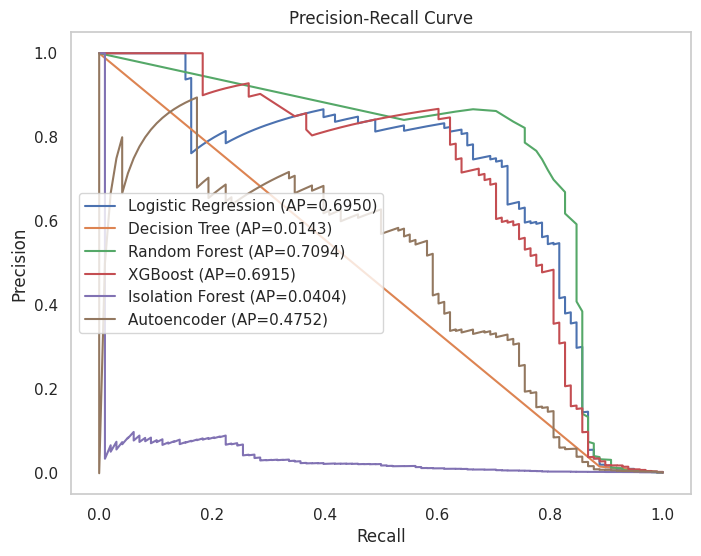

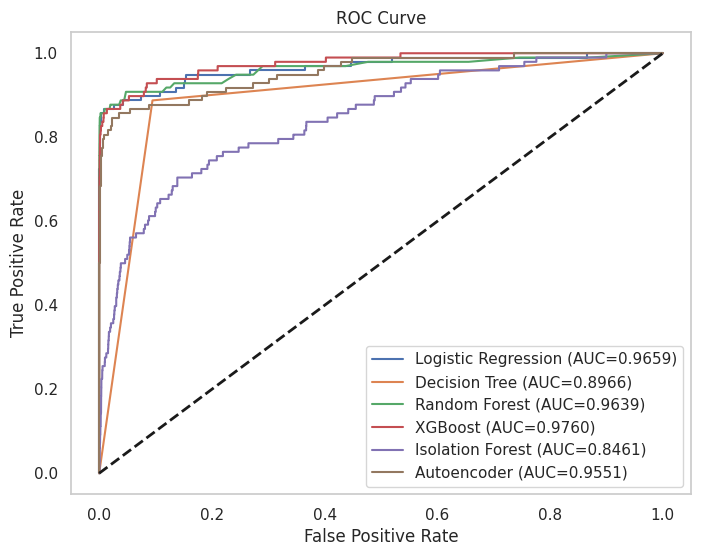

In [124]:
plot_pr_curves(results, y_test_common)
plot_roc_curves(results, y_test_common)

XGBoost가 성능은 가장 좋았고 AE 성능은 생각보다 좋게 나오진 않음